In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(f'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder =  '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Useful function for computing the PSNR

In [5]:
def compute_psnr(Y_true, Y_pred):
  mse = np.square(np.subtract(Y_true,Y_pred)).mean()
  #max_signal = np.max(Y_true)
  max_signal = 1
  return 10* np.log10(max_signal**2 / mse)

Useful function for plot a 2D dictionary

In [6]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [7]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x_OMP = np.zeros(N)
  # Support set
  omega = []
  # residual
  r = s

  # STOPPING CRITERIA
  while np.count_nonzero(x_OMP) < L and np.linalg.norm(r) > tau:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        zj = ((r.T @ dj) / np.linalg.norm(dj))**2
        e[j] = np.linalg.norm(r)**2 - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:, omega]
    D_omega_T_D_omega = np.dot(D_omega.T, D_omega)
    x_OMP[omega] = np.dot(np.linalg.inv(D_omega_T_D_omega), np.dot(D_omega.T, s))

    # update the residual
    r = s - np.dot(D, x_OMP)

  return x_OMP

Load the image and rescale it in $[0,1]$

In [8]:
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [9]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.normal(size=imsz)

Compute the PSNR of the noisy input

In [10]:
psnr_noisy = compute_psnr(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.13')

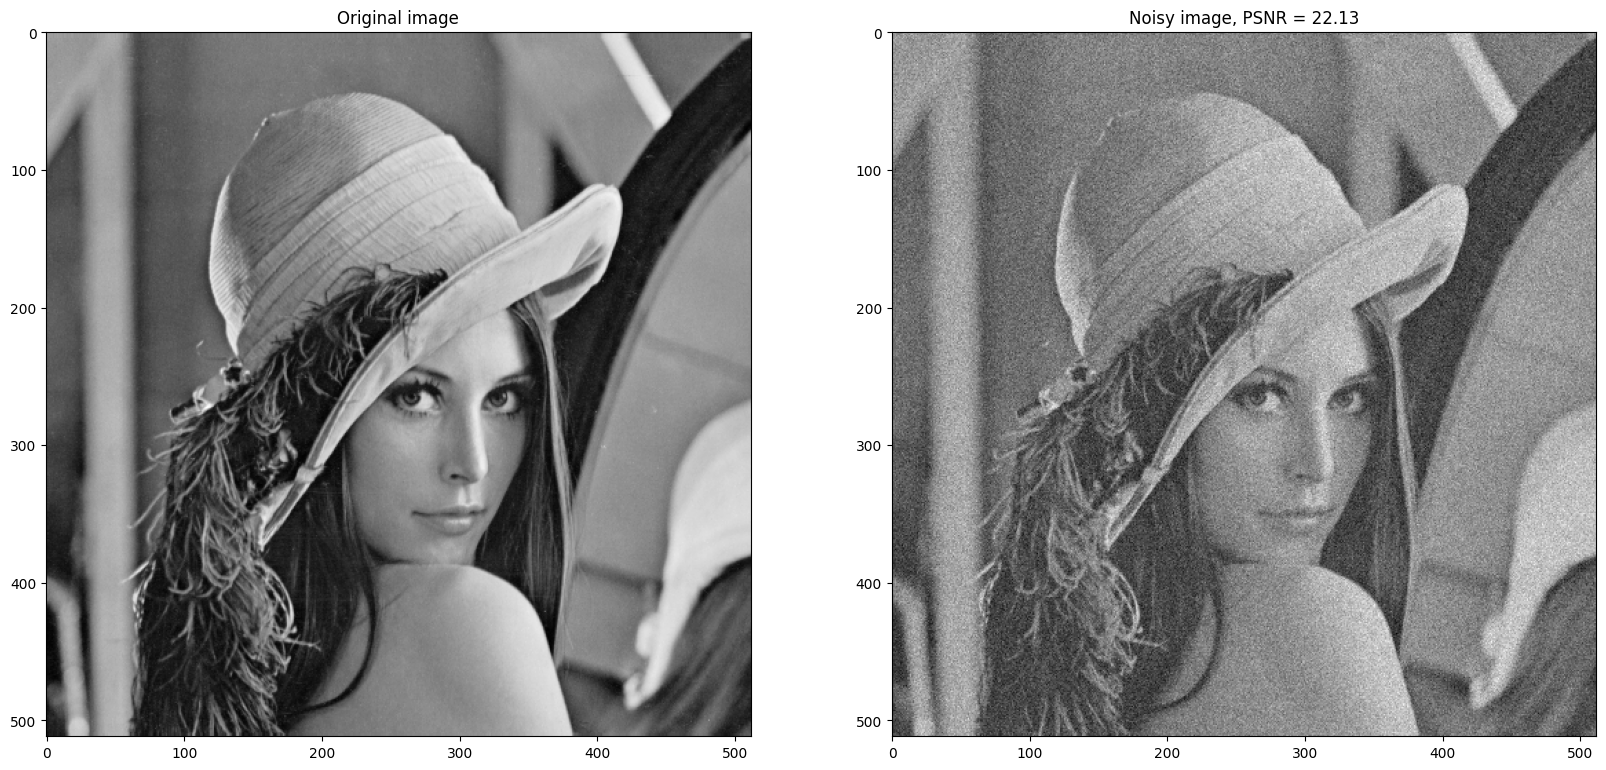

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Load and display the dictionary learned from patches

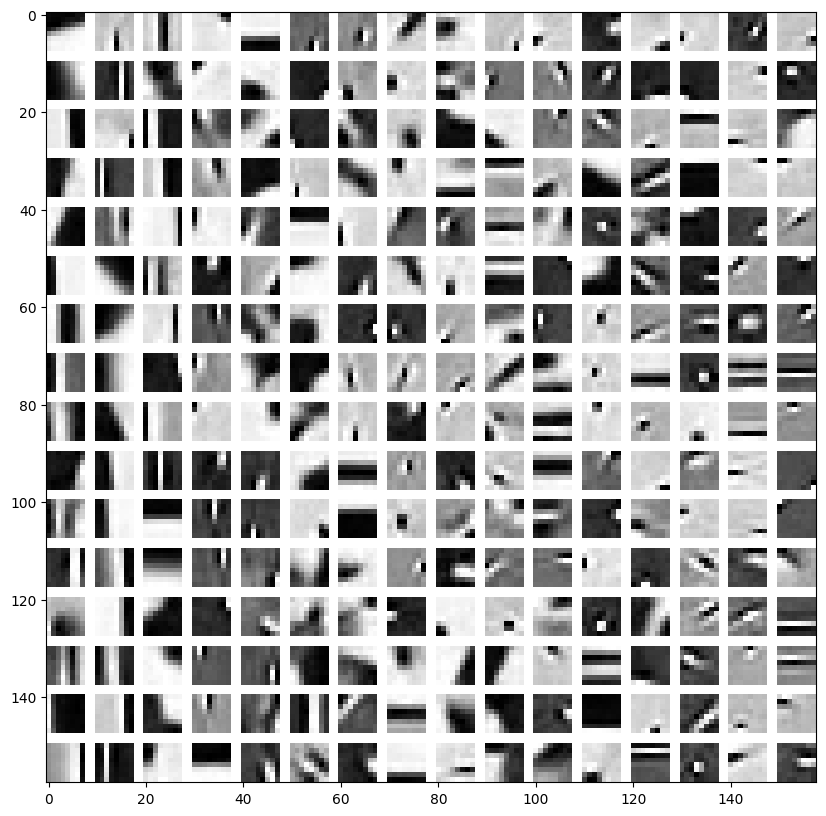

In [12]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the learned basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Denoising
---------


In [13]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [14]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i: i + p, j: j + p]

        # store and subtract the mean
        s_mean = np.mean(s)
        s = s - s_mean
        s = s.reshape(-1)

        # perform the sparse coding
        x = OMP(s, D, M, tau)

        # perform the reconstruction
        s_hat = np.dot(D, x)


        # add back the mean
        s_hat = s_hat.reshape((p, p))
        s_hat = s_hat + s_mean

        # compute the weight for the reconstructed patch
        w = 1

        # put the denoised patch into the estimated image using uniform weights
#        UPDATE img_hat
        img_hat[i: i + p, j: j + p] = img_hat[i: i + p, j: j + p] + w * s_hat


        # store the weight of the current patch in the weight matrix
#        UPDATE weights
        weights[i: i + p, j: j + p] = weights[i: i + p, j: j + p] + w

Normalize the estimated image with the computed weights

In [15]:
img_hat = img_hat / weights

Compute the PSNR of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 31.06 and STEP = 4')

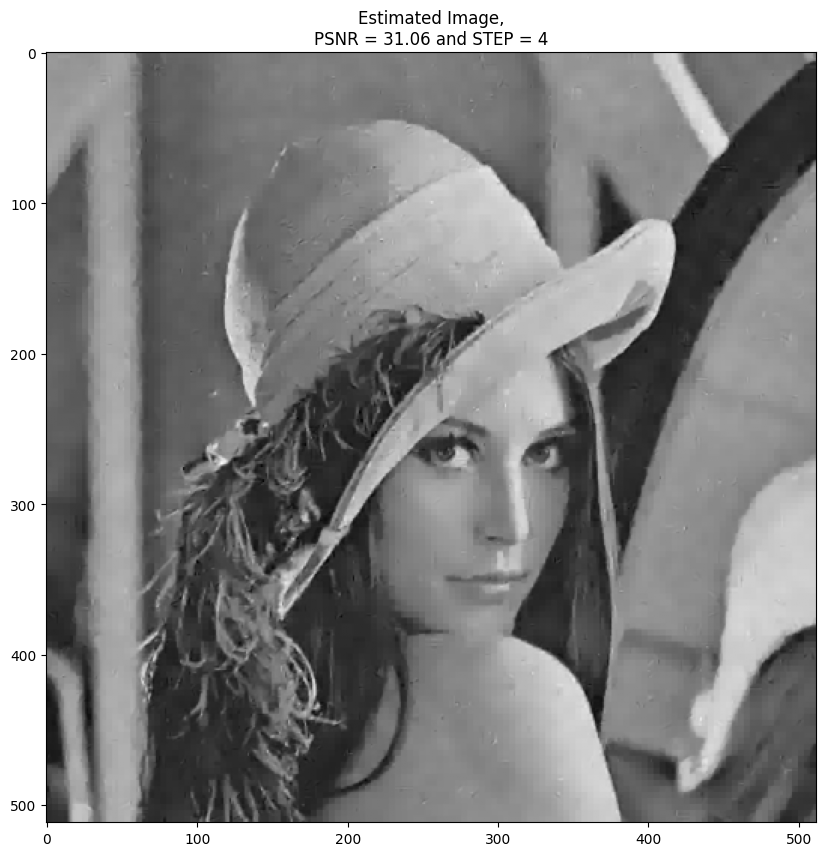

In [16]:
psnr_hat = compute_psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f} and STEP = {STEP}')
